In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split

In [2]:
df = pd.read_csv("./self-driving-data.csv")
df.drop(["Unnamed: 0"], inplace=True, axis=1)
df

,30,45,60,90,120,135,150,speed,label
0,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
1,1.442252,-0.169266,-0.728503,-1.127933,-0.801854,-0.169266,1.554570,0,0
2,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
3,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
4,1.480616,-0.167738,-0.747360,-1.173858,-0.747360,-0.148480,1.504180,23,0
...,...,...,...,...,...,...,...,...,...
29050,1.395053,-0.045195,-0.808261,-1.203214,-0.808261,-0.045195,1.515073,358,2
29051,1.463368,-0.065307,-0.801349,-1.193423,-0.801349,-0.065307,1.463368,367,2
29052,1.286868,-0.089803,-0.800793,-1.205045,-0.800793,-0.003265,1.612830,323,2
29053,1.367514,-0.096175,-0.805693,-1.215923,-0.757765,-0.046524,1.554566,323,2


In [3]:
labels = np.array(df["label"])
data = np.array(df[["30", "45", "60", "90", "120", "135", "150", "speed"]])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

# KNN

In [9]:
KNN = KNeighborsClassifier()

KNN.fit(X_train, y_train)

KNN.score(X_test, y_test)

0.3778287621232662

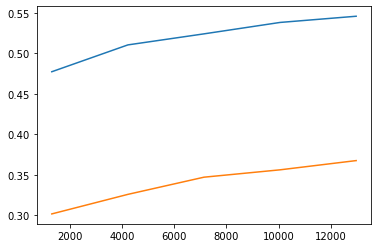

In [10]:
training_examples, train_score, valid_score = learning_curve(KNN, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [13]:
KNN = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ["ball_tree", "kd_tree"],
    'leaf_size': [8, 16, 32],
    'metric': ["euclidean", "minkowski", "manhattan"],
    'p': [1, 2],
}

grid = GridSearchCV(KNN, params, scoring="accuracy", cv=StratifiedKFold(3))
grid.fit(X_train, y_train)

print(grid.cv_results_)

{'mean_fit_time': array([0.01233697, 0.01129897, 0.01200128, 0.01066883, 0.01199698,
       0.01201256, 0.012012  , 0.01199985, 0.01066645, 0.00799982,
       0.01066629, 0.01199992, 0.01199985, 0.01199873, 0.01200088,
       0.01066629, 0.01165644, 0.01066637, 0.00936468, 0.01066486,
       0.01117229, 0.0086573 , 0.00933417, 0.01600115, 0.00968687,
       0.01000182, 0.01199992, 0.00933385, 0.01199913, 0.01066669,
       0.01066669, 0.00896835, 0.00931446, 0.00841085, 0.00999053,
       0.01000349, 0.00863957, 0.00866103, 0.0093267 , 0.01045696,
       0.01066661, 0.00853705, 0.00800069, 0.00932471, 0.00997615,
       0.0093147 , 0.00898147, 0.00965492, 0.00831509, 0.01000166,
       0.00934045, 0.01097242, 0.0090669 , 0.01098212, 0.01556683,
       0.0209473 , 0.01732071, 0.01631594, 0.01665076, 0.01774311,
       0.01600051, 0.01663923, 0.01605447, 0.01866539, 0.01600003,
       0.01601275, 0.0169603 , 0.01868065, 0.01600011, 0.01600035,
       0.01599979, 0.01865625, 0.01530782, 0

In [14]:
print(grid.best_estimator_)
print(grid.score(X_test, y_test))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=8, n_neighbors=7, p=1)
0.3938888309521327


In [15]:
np.unique(grid.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([  45, 5750, 1378, 1713,  480,  173,   31,   16,    3], dtype=int64))

# RF

In [16]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.5697152987798519

In [17]:
np.unique(rf.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([  98, 3750, 2087, 2476,  803,  292,   46,   34,    3], dtype=int64))

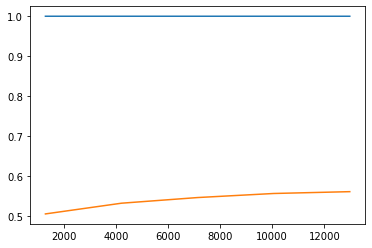

In [18]:
training_examples, train_score, valid_score = learning_curve(rf, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [20]:
rf = RandomForestClassifier()
params = {
    'n_estimators': [50, 100, 150],
    'criterion': ["gini", "log_loss", "entropy"],
    'max_depth': [None, 5, 10],
    'max_features': ["sqrt", "log2", "None"],
    'max_leaf_nodes': [None, 8, 10, 16, 32],
}

grid = GridSearchCV(rf, params, scoring="accuracy", cv=StratifiedKFold(3))
grid.fit(X_train, y_train)

print(grid.cv_results_)

C:\Users\wilso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wilso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wilso\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\wilso\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\wilso\anaconda3\lib\site-package

{'mean_fit_time': array([ 1.33704638,  2.6659387 ,  4.00279705,  0.43998694,  0.89489277,
        1.47179222,  0.47223552,  0.96257401,  1.44314361,  0.54006243,
        1.07358932,  1.68793901,  0.65869459,  1.3292129 ,  2.03879913,
        1.94197265,  4.02075648,  6.20082974,  0.71378072,  1.33478729,
        2.10786406,  0.73247139,  1.38372207,  1.99485485,  0.74340097,
        1.55518961,  2.32538891,  0.97843345,  1.8780822 ,  2.76123842,
        0.01937286,  0.03626307,  0.04933318,  0.01733303,  0.02933288,
        0.04399991,  0.01599987,  0.02933304,  0.04399999,  0.01599987,
        0.03066659,  0.04133296,  0.01599987,  0.03066675,  0.04764573,
        0.58463367,  1.26646296,  1.73015014,  0.50050497,  0.94679109,
        1.41793458,  0.52069696,  1.08583585,  1.5051868 ,  0.53791634,
        1.13430127,  1.62747471,  0.55151868,  1.19406422,  1.74472149,
        0.77236597,  1.63154984,  2.33070143,  0.66155664,  1.29214621,
        2.05101156,  0.71589065,  1.49851179, 

In [21]:
print(grid.best_estimator_)
print(grid.score(X_test, y_test))

RandomForestClassifier(criterion='log_loss', n_estimators=150)
0.5726353112941912


In [22]:
np.unique(grid.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 101, 3692, 2137, 2479,  806,  284,   48,   41,    1], dtype=int64))

# SVM

In [23]:
svm = SVC()
svm.fit(X_train, y_train)

svm.score(X_test, y_test)

0.337365731567421

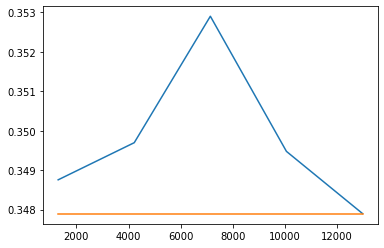

In [24]:
training_examples, train_score, valid_score = learning_curve(svm, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [25]:
scaler = MinMaxScaler((-1, 1))

In [27]:
# Non-linear
svm = SVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__kernel': ["rbf", "sigmoid"],
    'SVM__gamma': ["scale", "auto"],
    'SVM__class_weight': ["balanced"],
}


pipe = Pipeline(steps=[("scaler", scaler), ("SVM", svm)])

rscv = RandomizedSearchCV(pipe, params, scoring="accuracy", cv=StratifiedKFold(3), n_iter=8)
rscv.fit(X_train, y_train)

print(rscv.cv_results_)

{'mean_fit_time': array([14.57354021, 13.36744229, 19.72793516, 15.8088309 , 24.59926573,
       16.61237113, 15.4977959 , 22.48543779]), 'std_fit_time': array([0.6403231 , 0.36829745, 0.50216204, 0.3708878 , 0.92769817,
       0.82695045, 0.10233664, 1.2725358 ]), 'mean_score_time': array([ 8.69328372,  8.54722722,  9.04597624,  3.08654722,  4.09583473,
        9.28272867,  9.52869797, 10.19569747]), 'std_score_time': array([0.86324477, 0.0421147 , 0.2468126 , 0.15887575, 0.31150852,
       0.23434366, 0.4807333 , 0.55874122]), 'param_SVM__kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'sigmoid', 'sigmoid', 'rbf',
                   'rbf', 'rbf'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__gamma': masked_array(data=['auto', 'scale', 'auto', 'auto', 'scale', 'auto',
                   'scale', 'scale'],
             mask=[False, False, False, False, False, False, False, False],
       fill_

In [28]:
print(rscv.best_estimator_)
print(rscv.score(X_test, y_test))

Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('SVM', SVC(C=5, class_weight='balanced'))])
0.38773594743977474


In [29]:
np.unique(rscv.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 189, 1907, 1601, 1941,  262, 1188,  332, 1194,  975], dtype=int64))

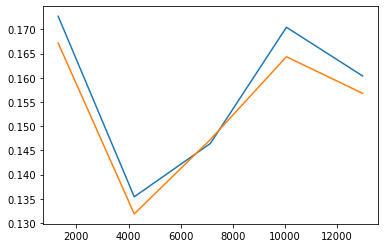

In [36]:
training_examples, train_score, valid_score = learning_curve(rscv.best_estimator_[1], X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [31]:
# Linear L2, Hinge loss
svm_h = LinearSVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__penalty': ["l2"],
    'SVM__loss': ["hinge"],
    'SVM__class_weight': ["balanced"],
    'SVM__max_iter': [300000],
    'SVM__tol': [1e-4],
}

pipe_h = Pipeline(steps=[("scaler", scaler), ("SVM", svm_h)])

grid_h = GridSearchCV(pipe_h, params, scoring="accuracy", cv=StratifiedKFold(3), error_score="raise")
grid_h.fit(X_train, y_train)

print(grid_h.cv_results_)

{'mean_fit_time': array([0.04409695, 0.05485376, 0.12265118, 0.21149898, 0.40543787]), 'std_fit_time': array([0.00481769, 0.0112835 , 0.01144422, 0.01508004, 0.01632739]), 'mean_score_time': array([0.0031565 , 0.00166265, 0.00098499, 0.00199596, 0.00162911]), 'std_score_time': array([1.61877980e-03, 4.71936327e-04, 2.13162151e-05, 1.25153985e-06,
       4.71889859e-04]), 'param_SVM__C': masked_array(data=[0.01, 0.1, 1, 2, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                   'balanced'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__loss': masked_array(data=['hinge', 'hinge', 'hinge', 'hinge', 'hinge'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__max_iter': masked_array(data=[300

In [32]:
print(grid_h.best_estimator_[1])
print(grid_h.score(X_test, y_test))
print(np.unique(grid_h.predict(X_test), return_counts=True))

LinearSVC(C=0.1, class_weight='balanced', loss='hinge', max_iter=300000)
0.21576806757743247
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([1015,  593,  665, 3188,  917,    1,  400,  509, 2301], dtype=int64))


In [33]:
# Linear Squared_hinge
svm_sh = LinearSVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__penalty': ["l1", "l2"],
    'SVM__dual': [False],
    'SVM__loss': ["squared_hinge"],
    'SVM__class_weight': ["balanced"],
    'SVM__max_iter': [300000],
    'SVM__tol': [1e-4],
}

pipe_sh = Pipeline(steps=[("scaler", scaler), ("SVM", svm_sh)])

grid_sh = GridSearchCV(pipe_sh, params, scoring="accuracy", cv=StratifiedKFold(3), error_score="raise")
grid_sh.fit(X_train, y_train)

print(grid_sh.cv_results_)

{'mean_fit_time': array([ 0.76792741,  0.10354416,  7.68747131,  0.12187958, 30.17026552,
        0.12201929, 36.39457726,  0.15759913, 52.48580082,  0.1169068 ]), 'std_fit_time': array([1.75139162e-01, 6.42500111e-03, 5.15805340e+00, 3.75949794e-03,
       1.43181333e+01, 9.27832967e-03, 8.23775972e+00, 3.18524064e-02,
       1.34238709e+01, 3.15884399e-03]), 'mean_score_time': array([0.00131647, 0.00131671, 0.00156641, 0.00198142, 0.00146675,
       0.00199374, 0.0019838 , 0.00198809, 0.00200669, 0.0019722 ]), 'std_score_time': array([4.79859364e-04, 4.78692987e-04, 4.19783740e-04, 1.61636934e-05,
       4.10106616e-04, 2.95897426e-05, 8.31072640e-04, 8.71089251e-06,
       3.65355675e-05, 1.69293980e-05]), 'param_SVM__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 2, 2, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_SVM__class_weight': masked_array(data=[

In [34]:
print(grid_sh.best_estimator_[1])
print(grid_sh.score(X_test, y_test))
print(np.unique(grid_sh.predict(X_test), return_counts=True))

LinearSVC(C=5, class_weight='balanced', dual=False, max_iter=300000,
          penalty='l1')
0.44926478256335384
(array([0, 1, 2, 3, 4, 5, 7], dtype=int64), array([ 612, 3496, 2134, 2169,  490,  652,   36], dtype=int64))


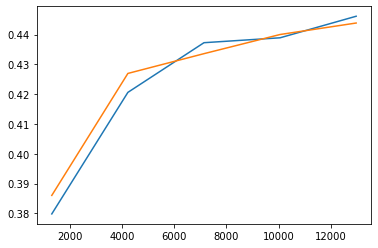

In [35]:
training_examples, train_score, valid_score = learning_curve(grid_sh.best_estimator_[1], 
                                                             X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

# Neural Nets

In [58]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(8, )))
#     for i in range(hp.Int("n_layers", 1, 3)):
    model.add(Dense(hp.Int("n_neurons", 64, 208, 16), activation="softmax"))
    model.add(Dense(8, activation="softmax"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    hp_beta_1 = hp.Choice("beta_1", values=[0.9, 0.85, 0.95])
    hp_beta_2 = hp.Choice("beta_2", values=[0.999, 0.99, 0.9999])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=100, overwrite=False)
tuner.search(x=X_train, y=y_train, epochs=120, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback])

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [61]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 128
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.99
Score: 0.5083950161933899
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 96
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.9999
Score: 0.5020335912704468
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 96
learning_rate: 0.0001
beta_1: 0.9
beta_2: 0.99
Score: 0.490353524684906
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 160
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.9999
Score: 0.3541558086872101
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 176
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.9999
Score: 0.35405153036117554
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 112
learning_rate: 1e-05
beta_1: 0.85
beta_2: 0.999
Score: 0.3539472222328186
Trial summary
Hyperparameters:
n_layers: 1
n_neurons: 160
learning_rate: 1e-05
beta_1: 0.95
be

In [5]:
def build_model_a(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.99)):
    model = tf.keras.Sequential()
    model.add(Dense(128, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [6]:
def build_model_b(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999)):
    model = tf.keras.Sequential()
    model.add(Dense(96, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [7]:
def build_model_c(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.99)):
    model = tf.keras.Sequential()
    model.add(Dense(96, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [62]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [68]:
history = model.fit(X_train, y_train, epochs=750, validation_split=0.33)

Epoch 1/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6699 - accuracy: 0.3620 - val_loss: 1.6581 - val_accuracy: 0.3649
Epoch 2/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6636 - accuracy: 0.3667 - val_loss: 1.6520 - val_accuracy: 0.3726
Epoch 3/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6588 - accuracy: 0.3699 - val_loss: 1.6500 - val_accuracy: 0.3742
Epoch 4/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6545 - accuracy: 0.3700 - val_loss: 1.6397 - val_accuracy: 0.3711
Epoch 5/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6445 - accuracy: 0.3718 - val_loss: 1.6368 - val_accuracy: 0.3657
Epoch 6/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6369 - accuracy: 0.3734 - val_loss: 1.6227 - val_accuracy: 0.3695
Epoch 7/750
408/408 [==============================] - 2s 5ms/step - loss: 1.6252 - accuracy: 0.3795 - val_loss: 1.6116 - val_accuracy: 0.3734

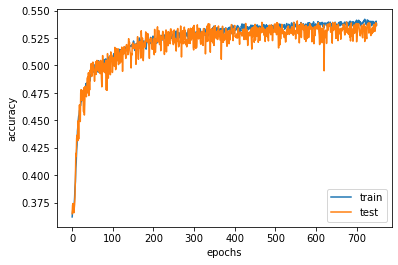

In [83]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

val_acc_epoch = history.history["val_accuracy"]
best_epoch = val_acc_epoch.index(max(val_acc_epoch)) + 1

In [72]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.33)

Epoch 1/555
408/408 [==============================] - 3s 6ms/step - loss: 1.8619 - accuracy: 0.3145 - val_loss: 1.7500 - val_accuracy: 0.3579
Epoch 2/555
408/408 [==============================] - 1s 4ms/step - loss: 1.7142 - accuracy: 0.3595 - val_loss: 1.6912 - val_accuracy: 0.3579
Epoch 3/555
408/408 [==============================] - 2s 4ms/step - loss: 1.6870 - accuracy: 0.3595 - val_loss: 1.6806 - val_accuracy: 0.3579
Epoch 4/555
408/408 [==============================] - 2s 4ms/step - loss: 1.6815 - accuracy: 0.3595 - val_loss: 1.6779 - val_accuracy: 0.3579
Epoch 5/555
408/408 [==============================] - 1s 3ms/step - loss: 1.6794 - accuracy: 0.3595 - val_loss: 1.6740 - val_accuracy: 0.3579
Epoch 6/555
408/408 [==============================] - 2s 4ms/step - loss: 1.6788 - accuracy: 0.3595 - val_loss: 1.6761 - val_accuracy: 0.3579
Epoch 7/555
408/408 [==============================] - 2s 4ms/step - loss: 1.6748 - accuracy: 0.3599 - val_loss: 1.6690 - val_accuracy: 0.3619

In [76]:
print(np.unique(np.argmax(model.predict(X_test), axis=1), return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

300/300 [==============================] - 0s 1ms/step
(array([0, 1, 2, 3, 6, 7], dtype=int64), array([4902, 2296,  168,    3,   74, 2146], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([3428, 1921, 1193,  300,   71,  353,  605, 1718], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([6987, 3963, 2451,  579,  132,  597, 1170, 3587], dtype=int64))


In [77]:
model.evaluate(X_test, y_test)

300/300 [==============================] - 1s 3ms/step - loss: 1.3264 - accuracy: 0.5162


[1.3264199495315552, 0.516216516494751]

In [79]:
model_b = build_model_b()
model_c = build_model_c()

hist1 = model_b.fit(X_train, y_train, epochs=750, validation_split=0.33)
hist2 = model_c.fit(X_train, y_train, epochs=750, validation_split=0.33)

Epoch 1/750
408/408 [==============================] - 2s 4ms/step - loss: 1.8293 - accuracy: 0.3508 - val_loss: 1.7393 - val_accuracy: 0.3579
Epoch 2/750
408/408 [==============================] - 1s 4ms/step - loss: 1.7143 - accuracy: 0.3595 - val_loss: 1.6958 - val_accuracy: 0.3579
Epoch 3/750
408/408 [==============================] - 2s 4ms/step - loss: 1.6915 - accuracy: 0.3595 - val_loss: 1.6848 - val_accuracy: 0.3579
Epoch 4/750
408/408 [==============================] - 2s 4ms/step - loss: 1.6846 - accuracy: 0.3595 - val_loss: 1.6801 - val_accuracy: 0.3579
Epoch 5/750
408/408 [==============================] - 1s 4ms/step - loss: 1.6793 - accuracy: 0.3608 - val_loss: 1.6712 - val_accuracy: 0.3639
Epoch 6/750
408/408 [==============================] - 2s 4ms/step - loss: 1.6710 - accuracy: 0.3670 - val_loss: 1.6626 - val_accuracy: 0.3674
Epoch 7/750
408/408 [==============================] - 2s 4ms/step - loss: 1.6632 - accuracy: 0.3707 - val_loss: 1.6552 - val_accuracy: 0.3702

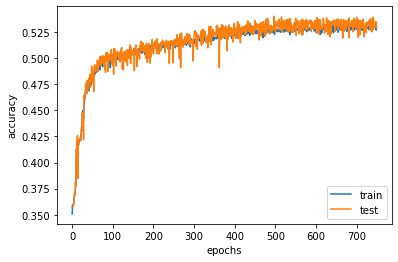

In [80]:
plt.plot(hist1.history["accuracy"], label="accuracy")
plt.plot(hist1.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

In [84]:
val_acc_epoch = hist1.history["val_accuracy"]
best_epoch_b = val_acc_epoch.index(max(val_acc_epoch)) + 1

model_b = build_model_b()
model_b.fit(X_train, y_train, epochs=best_epoch_b, validation_split=0.33)

Epoch 1/498
408/408 [==============================] - 3s 6ms/step - loss: 1.6971 - accuracy: 0.3591 - val_loss: 1.6764 - val_accuracy: 0.3579
Epoch 2/498
408/408 [==============================] - 2s 4ms/step - loss: 1.6795 - accuracy: 0.3595 - val_loss: 1.6767 - val_accuracy: 0.3579
Epoch 3/498
408/408 [==============================] - 2s 4ms/step - loss: 1.6789 - accuracy: 0.3595 - val_loss: 1.6760 - val_accuracy: 0.3579
Epoch 4/498
408/408 [==============================] - 1s 4ms/step - loss: 1.6786 - accuracy: 0.3595 - val_loss: 1.6756 - val_accuracy: 0.3579
Epoch 5/498
408/408 [==============================] - 2s 4ms/step - loss: 1.6780 - accuracy: 0.3595 - val_loss: 1.6754 - val_accuracy: 0.3579
Epoch 6/498
408/408 [==============================] - 2s 4ms/step - loss: 1.6779 - accuracy: 0.3595 - val_loss: 1.6751 - val_accuracy: 0.3580
Epoch 7/498
408/408 [==============================] - 2s 4ms/step - loss: 1.6777 - accuracy: 0.3596 - val_loss: 1.6750 - val_accuracy: 0.3580

In [85]:
np.unique(np.argmax(model_b.predict(X_test), axis=1), return_counts=True)

300/300 [==============================] - 0s 1ms/step


(array([0, 1, 2, 3, 6, 7], dtype=int64),
 array([4558, 2466,  220,    3,    3, 2339], dtype=int64))

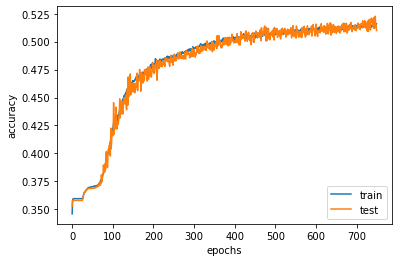

In [86]:
plt.plot(hist2.history["accuracy"], label="accuracy")
plt.plot(hist2.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

In [88]:
val_acc_epoch = hist2.history["val_accuracy"]
best_epoch_c = val_acc_epoch.index(max(val_acc_epoch)) + 1

model_c = build_model_c()
model_c.fit(X_train, y_train, epochs=best_epoch_c, validation_split=0.33)

Epoch 1/747
408/408 [==============================] - 2s 4ms/step - loss: 2.0346 - accuracy: 0.2405 - val_loss: 1.9755 - val_accuracy: 0.3573
Epoch 2/747
408/408 [==============================] - 1s 4ms/step - loss: 1.9447 - accuracy: 0.2156 - val_loss: 1.9211 - val_accuracy: 0.1912
Epoch 3/747
408/408 [==============================] - 2s 4ms/step - loss: 1.9036 - accuracy: 0.2740 - val_loss: 1.8855 - val_accuracy: 0.3579
Epoch 4/747
408/408 [==============================] - 2s 4ms/step - loss: 1.8709 - accuracy: 0.3595 - val_loss: 1.8547 - val_accuracy: 0.3579
Epoch 5/747
408/408 [==============================] - 2s 4ms/step - loss: 1.8421 - accuracy: 0.3595 - val_loss: 1.8275 - val_accuracy: 0.3579
Epoch 6/747
408/408 [==============================] - 2s 5ms/step - loss: 1.8168 - accuracy: 0.3595 - val_loss: 1.8036 - val_accuracy: 0.3579
Epoch 7/747
408/408 [==============================] - 2s 5ms/step - loss: 1.7946 - accuracy: 0.3595 - val_loss: 1.7828 - val_accuracy: 0.3579

In [94]:
model_c.fit(X_train, y_train, epochs=200, validation_split=0.33)

Epoch 1/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4026 - accuracy: 0.4873 - val_loss: 1.4083 - val_accuracy: 0.4833
Epoch 2/200
408/408 [==============================] - 1s 4ms/step - loss: 1.4026 - accuracy: 0.4884 - val_loss: 1.4089 - val_accuracy: 0.4877
Epoch 3/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4026 - accuracy: 0.4877 - val_loss: 1.4096 - val_accuracy: 0.4889
Epoch 4/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4024 - accuracy: 0.4883 - val_loss: 1.4103 - val_accuracy: 0.4860
Epoch 5/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4013 - accuracy: 0.4891 - val_loss: 1.4091 - val_accuracy: 0.4852
Epoch 6/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4015 - accuracy: 0.4887 - val_loss: 1.4077 - val_accuracy: 0.4871
Epoch 7/200
408/408 [==============================] - 2s 4ms/step - loss: 1.4013 - accuracy: 0.4893 - val_loss: 1.4079 - val_accuracy: 0.4837

In [95]:
np.unique(np.argmax(model_c.predict(X_test), axis=1), return_counts=True)

300/300 [==============================] - 0s 2ms/step


(array([0, 1, 2, 7], dtype=int64),
 array([5069, 2171,  207, 2142], dtype=int64))

In [96]:
print(model.evaluate(X_test, y_test))
print(model_b.evaluate(X_test, y_test))
print(model_c.evaluate(X_test, y_test))

300/300 [==============================] - 1s 3ms/step - loss: 1.3264 - accuracy: 0.5162
[1.3264199495315552, 0.516216516494751]
300/300 [==============================] - 1s 2ms/step - loss: 1.3454 - accuracy: 0.5177
[1.345361590385437, 0.5176765322685242]
300/300 [==============================] - 1s 2ms/step - loss: 1.4003 - accuracy: 0.5029
[1.4002587795257568, 0.5028678774833679]


In [91]:
mlp = MLPClassifier(max_iter=10000, learning_rate="adaptive")

mlp.fit(X_train, y_train)

mlp.score(X_test, y_test)

0.44175617895505265

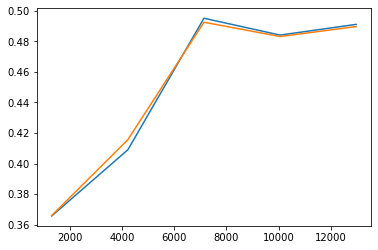

In [92]:
training_examples, train_score, valid_score = learning_curve(mlp, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [93]:
np.unique(mlp.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 5, 6, 7], dtype=int64),
 array([1841, 4107, 1088,    1,    1,   21, 2530], dtype=int64))

# Ensemble

In [8]:
a = KerasClassifier(build_model_a, epochs=400, batch_size=10)
a._estimator_type = "classifier"
b = KerasClassifier(build_model_b, epochs=400, batch_size=10)
b._estimator_type = "classifier"
c = KerasClassifier(build_model_c, epochs=600, batch_size=10)
c._estimator_type = "classifier"

<ipython-input-8-d74c2453f9b4>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  a = KerasClassifier(build_model_a, epochs=400, batch_size=10)
<ipython-input-8-d74c2453f9b4>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  b = KerasClassifier(build_model_b, epochs=400, batch_size=10)
<ipython-input-8-d74c2453f9b4>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  c = KerasClassifier(build_model_c, epochs=600, batch_size=10)


In [9]:
ens = VotingClassifier([("a", a), ("b", b), ("c", c)], voting="hard", weights=[0.37, 0.33, 0.3])

In [10]:
ens.fit(X_train, y_train)

Epoch 1/400
1947/1947 [==============================] - 8s 3ms/step - loss: 1.7451 - accuracy: 0.3442
Epoch 2/400
1947/1947 [==============================] - 7s 4ms/step - loss: 1.6940 - accuracy: 0.3519
Epoch 3/400
1947/1947 [==============================] - 8s 4ms/step - loss: 1.6929 - accuracy: 0.3519
Epoch 4/400
1947/1947 [==============================] - 8s 4ms/step - loss: 1.6924 - accuracy: 0.3519
Epoch 5/400
1947/1947 [==============================] - 9s 5ms/step - loss: 1.6922 - accuracy: 0.3519
Epoch 6/400
1947/1947 [==============================] - 8s 4ms/step - loss: 1.6883 - accuracy: 0.3525
Epoch 7/400
1947/1947 [==============================] - 7s 4ms/step - loss: 1.6803 - accuracy: 0.3609
Epoch 8/400
1947/1947 [==============================] - 6s 3ms/step - loss: 1.6723 - accuracy: 0.3637
Epoch 9/400
1947/1947 [==============================] - 7s 4ms/step - loss: 1.6512 - accuracy: 0.3737
Epoch 10/400
1947/1947 [==============================] - 8s 4ms/step - l

VotingClassifier(estimators=[('a',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028F73A5FE20>),
                             ('b',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028F73A5FFD0>),
                             ('c',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028F73A5FFA0>)],
                 weights=[0.37, 0.33, 0.3])

In [11]:
ens.score(X_test, y_test)

300/300 [==============================] - 1s 2ms/step


0.5303994159974972

In [12]:
np.unique(ens.predict(X_test), return_counts=True)

300/300 [==============================] - 1s 2ms/step


(array([0, 1, 2, 3, 6, 7], dtype=int64),
 array([4502, 2619,  134,    1,   81, 2252], dtype=int64))